In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('Ops').getOrCreate()

In [3]:
File_2021 = ("dbfs:/FileStore/tables/clinicaltrial_2021.csv.gz")

In [4]:
File_mesh = ("dbfs:/FileStore/tables/mesh.csv")

In [5]:
File_Pharma = ("dbfs:/FileStore/tables/pharma.csv")

In [6]:
df_2021 = spark.read.options(delimiter = "|", header = True, inferSchema=True).csv("/home/ec2-user/clinicaltrial_2021.csv.gz")

In [7]:
DF_mesh = spark.read.options(delimiter = ",", header = True, inferSchema=True).csv("/home/ec2-user/mesh.csv")

In [8]:
Df_pharma = spark.read.options(delimiter = ",", header = True, inferSchema = True).csv("/home/ec2-user/pharma.csv")

In [9]:
df_2021.count()

387261

In [10]:
df_2021_type = df_2021.groupby(["Type"]).count()
df_2021_type_Frequency = df_2021_type.orderBy(["count"] , ascending = False)
df_2021_type_Frequency.show(truncate=False)

+--------------------------------+------+
|Type                            |count |
+--------------------------------+------+
|Interventional                  |301472|
|Observational                   |77540 |
|Observational [Patient Registry]|8180  |
|Expanded Access                 |69    |
+--------------------------------+------+



In [11]:
from pyspark.sql.functions import *
split_Condition_explode2021 = df_2021.withColumn('Conditions',explode(split(df_2021['conditions'],',')))
split_Condition_explode2021.show(truncate=False)

+-----------+------------------------------------------------------+----------------------+--------+----------+--------------------------------+----------+------------------------+----------------------------------------------------------------------+
|Id         |Sponsor                                               |Status                |Start   |Completion|Type                            |Submission|Conditions              |Interventions                                                         |
+-----------+------------------------------------------------------+----------------------+--------+----------+--------------------------------+----------+------------------------+----------------------------------------------------------------------+
|NCT02751957|Duke University                                       |Completed             |Jul 2016|Jul 2020  |Interventional                  |Apr 2016  |Autistic Disorder       |null                                                            

In [12]:
Count_conditions_2021 = split_Condition_explode2021.groupby(["Conditions"]).count()
count_display_2021 = Count_conditions_2021.orderBy(["count"], ascending = False)
count_display_2021.show(5, truncate=False)

+-----------------+-----+
|Conditions       |count|
+-----------------+-----+
|Carcinoma        |13389|
|Diabetes Mellitus|11080|
|Neoplasms        |9371 |
|Breast Neoplasms |8640 |
|Syndrome         |8032 |
+-----------------+-----+
only showing top 5 rows



In [13]:
Innerjoin_mesh_explode_2021 = split_Condition_explode2021.join(DF_mesh.withColumn('root', DF_mesh.tree.substr(1,3)), split_Condition_explode2021.Conditions == DF_mesh.withColumn('root', DF_mesh.tree.substr(1,3)).term, how = 'inner').groupby(["root"]).count().orderBy(["count"], ascending = False)
Innerjoin_mesh_explode_2021.show(5, truncate=False)

+----+------+
|root|count |
+----+------+
|C04 |143994|
|C23 |136079|
|C01 |106674|
|C14 |94523 |
|C10 |92310 |
+----+------+
only showing top 5 rows



In [14]:
leftjoined_pharma_2021 = df_2021.join(Df_pharma, df_2021.Sponsor == Df_pharma.Parent_Company, how = 'left').select("Sponsor", 'Parent_Company').where('Parent_Company is null').groupby(["Sponsor"]).count().orderBy(["count"], ascending = False)
leftjoined_pharma_2021.show(10, truncate=False)

+---------------------------------------+-----+
|Sponsor                                |count|
+---------------------------------------+-----+
|National Cancer Institute (NCI)        |3218 |
|M.D. Anderson Cancer Center            |2414 |
|Assistance Publique - Hôpitaux de Paris|2369 |
|Mayo Clinic                            |2300 |
|Merck Sharp & Dohme Corp.              |2243 |
|Assiut University                      |2154 |
|Novartis Pharmaceuticals               |2088 |
|Massachusetts General Hospital         |1971 |
|Cairo University                       |1928 |
|Hoffmann-La Roche                      |1828 |
+---------------------------------------+-----+
only showing top 10 rows



In [15]:
Finaljoin2021_substring= df_2021.select(["Status", "Completion"]).filter(df_2021.Status == 'Completed').withColumn('Month',split(df_2021.select(["Status", "Completion"]).filter(df_2021.Status == 'Completed')['Completion'],' ').getItem(0)) \
.withColumn('Year',split(df_2021.select(["Status", "Completion"]).filter(df_2021.Status == 'Completed')['Completion'],' ').getItem(1))
Finaljoin2021_substring.show(truncate=False)

+---------+----------+-----+----+
|Status   |Completion|Month|Year|
+---------+----------+-----+----+
|Completed|Jul 2020  |Jul  |2020|
|Completed|Jan 2018  |Jan  |2018|
|Completed|Dec 2014  |Dec  |2014|
|Completed|Jan 2018  |Jan  |2018|
|Completed|Jul 2017  |Jul  |2017|
|Completed|Jan 2021  |Jan  |2021|
|Completed|Oct 2016  |Oct  |2016|
|Completed|Dec 2015  |Dec  |2015|
|Completed|Mar 2016  |Mar  |2016|
|Completed|May 2019  |May  |2019|
|Completed|Oct 2019  |Oct  |2019|
|Completed|Apr 2015  |Apr  |2015|
|Completed|Jan 2016  |Jan  |2016|
|Completed|null      |null |null|
|Completed|Apr 2017  |Apr  |2017|
|Completed|Nov 2020  |Nov  |2020|
|Completed|Jul 2017  |Jul  |2017|
|Completed|Jun 2021  |Jun  |2021|
|Completed|Mar 2017  |Mar  |2017|
|Completed|Apr 2018  |Apr  |2018|
+---------+----------+-----+----+
only showing top 20 rows



In [16]:
Count_Month_2021 = Finaljoin2021_substring.select(["Month", "Year"]).filter(Finaljoin2021_substring.Year == '2021').groupby(["Month"]).count().orderBy(["Month"], ascending = False)
Count_Month_2021.show()

+-----+-----+
|Month|count|
+-----+-----+
|  Sep|  528|
|  Oct|  187|
|  May|  984|
|  Mar| 1227|
|  Jun| 1094|
|  Jul|  819|
|  Jan| 1131|
|  Feb|  934|
|  Aug|  700|
|  Apr|  967|
+-----+-----+



In [17]:
from pyspark.sql.functions import *
Month_display_sort_2021 = Count_Month_2021.sort(unix_timestamp(col("Month"),"MMM")).withColumnRenamed("count","2021")
Month_display_sort_2021.show()

+-----+----+
|Month|2021|
+-----+----+
|  Jan|1131|
|  Feb| 934|
|  Mar|1227|
|  Apr| 967|
|  May| 984|
|  Jun|1094|
|  Jul| 819|
|  Aug| 700|
|  Sep| 528|
|  Oct| 187|
+-----+----+



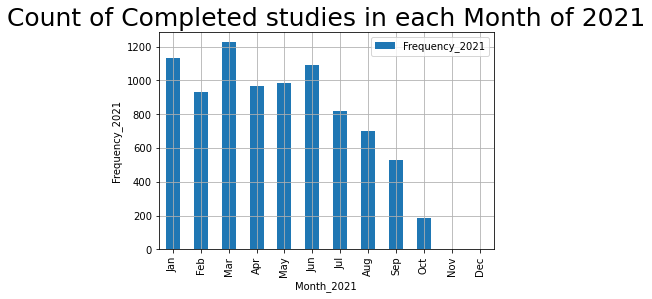

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

Input = {'Month_2021': ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
        'Frequency_2021': [1131, 934, 1227, 967,984,1094,819,700,528,187,0,0]
       }
df = pd.DataFrame(Input,columns=['Month_2021','Frequency_2021'])
df.plot(x ='Month_2021', y='Frequency_2021', kind = 'bar')
plt.title("Count of Completed studies in each Month of 2021", fontsize=25)
plt.xlabel("Month_2021")
plt.ylabel("Frequency_2021")
plt.grid()
plt.show()

In [19]:
Uncompleted_studies2021= df_2021.select(["Status", "Completion"]).filter(df_2021.Status != 'Completed').withColumn('Month',split(df_2021.select(["Status", "Completion"]).filter(df_2021.Status != 'Completed')['Completion'],' ').getItem(0)) \
.withColumn('Year',split(df_2021.select(["Status", "Completion"]).filter(df_2021.Status != 'Completed')['Completion'],' ').getItem(1))
Uncompleted_studies2021.show(truncate=False)

+----------------------+----------+-----+----+
|Status                |Completion|Month|Year|
+----------------------+----------+-----+----+
|Recruiting            |Nov 2021  |Nov  |2021|
|Active, not recruiting|Sep 2020  |Sep  |2020|
|Unknown status        |Jul 2017  |Jul  |2017|
|Unknown status        |Nov 2019  |Nov  |2019|
|Active, not recruiting|Dec 2021  |Dec  |2021|
|Unknown status        |Jun 2017  |Jun  |2017|
|Terminated            |Jul 2016  |Jul  |2016|
|Unknown status        |Dec 2018  |Dec  |2018|
|Recruiting            |Oct 2022  |Oct  |2022|
|Unknown status        |Jun 2019  |Jun  |2019|
|Unknown status        |Jun 2020  |Jun  |2020|
|Unknown status        |Dec 2016  |Dec  |2016|
|Withdrawn             |null      |null |null|
|Terminated            |Jul 2017  |Jul  |2017|
|Unknown status        |Dec 2017  |Dec  |2017|
|Unknown status        |Dec 2018  |Dec  |2018|
|Unknown status        |Dec 2020  |Dec  |2020|
|Recruiting            |Jan 2023  |Jan  |2023|
|Active, not 

In [20]:
Uncompleted_studies_Count_Month_2021 = Uncompleted_studies2021.select(["Month", "Year"]).filter(Uncompleted_studies2021.Year == '2021').groupby(["Month"]).count().orderBy(["Month"], ascending = False)
uncompletedMonth_display_sort_2021 = Uncompleted_studies_Count_Month_2021.sort(unix_timestamp(col("Month"),"MMM")).withColumnRenamed("count","2021")
uncompletedMonth_display_sort_2021.show()

+-----+----+
|Month|2021|
+-----+----+
|  Jan| 980|
|  Feb| 801|
|  Mar|1220|
|  Apr|1062|
|  May|1128|
|  Jun|2008|
|  Jul|1589|
|  Aug|1603|
|  Sep|2373|
|  Oct|2327|
|  Nov|1997|
|  Dec|9968|
+-----+----+



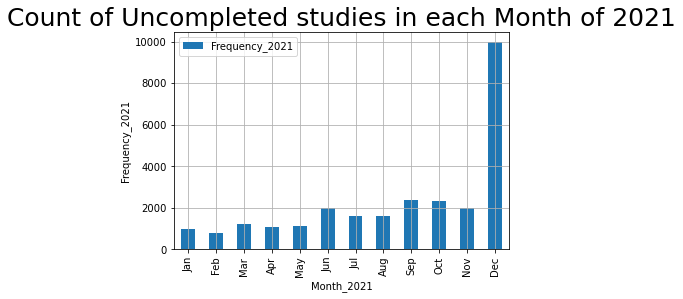

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
 
Input = {'Month_2021': ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
        'Frequency_2021': [980, 801, 1220, 1062,1128,2008,1589,1603,2373,2327,1997,9968]
       }
df = pd.DataFrame(Input,columns=['Month_2021','Frequency_2021'])
df.plot(x ='Month_2021', y='Frequency_2021', kind = 'bar')
plt.title("Count of Uncompleted studies in each Month of 2021", fontsize=25)
plt.xlabel("Month_2021")
plt.ylabel("Frequency_2021")
plt.grid()
plt.show()

In [24]:
Uncompleted_status_studies2021= df_2021.select(["Status", "Completion"]).filter(df_2021.Status != 'Completed')
trim_completion = Uncompleted_status_studies2021.withColumn('Year', Uncompleted_status_studies2021.Completion.substr(5,8))
Uncompleted_status_studies_Count_Month_2021 = trim_completion.select(["Status", "Year"]).filter(trim_completion.Year == '2021').groupby(["Status"]).count().orderBy(["Status"], ascending = False)
Uncompleted_status_studies_Count_Month_2021.show(truncate=False)

+-----------------------+-----+
|Status                 |count|
+-----------------------+-----+
|Withdrawn              |753  |
|Unknown status         |2289 |
|Terminated             |803  |
|Suspended              |306  |
|Recruiting             |12902|
|Not yet recruiting     |2958 |
|Enrolling by invitation|918  |
|Active, not recruiting |6127 |
+-----------------------+-----+



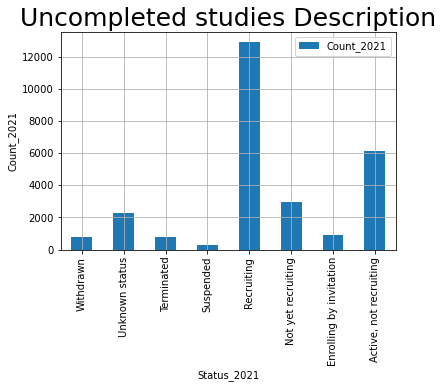

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
 
Input = {'Status_2021': ['Withdrawn', 'Unknown status', 'Terminated', 'Suspended','Recruiting','Not yet recruiting','Enrolling by invitation','Active, not recruiting'],
        'Count_2021': [753, 2289, 803, 306,12902,2958,918,6127]
       }
df = pd.DataFrame(Input,columns=['Status_2021','Count_2021'])
df.plot(x ='Status_2021', y='Count_2021', kind = 'bar')
plt.title("Uncompleted studies Description", fontsize=25)
plt.xlabel("Status_2021")
plt.ylabel("Count_2021")
plt.grid()
plt.show()

In [26]:
!pip install wordcloud

     |████████████████████████████████| 366 kB 24.1 MB/s            


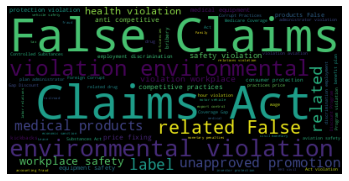

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
Column = ['Primary_Offense']
DF_1 = pd.read_csv('/home/ec2-user/pharma.csv', usecols=Column)
 
FinalDF_1 = ' '.join(DF_1['Primary_Offense']) 
Finalwordcloud = WordCloud().generate(FinalDF_1)
# Generate plot
plt.imshow(Finalwordcloud)
plt.axis("off")
plt.show()
